# Introduction
The aim of this course work project is to create the best neural network to correctly classify a dataset consisting of 100 different classes of images. The previous coursework was limited to dense and dropout layers while this project will be able to apply the use of more advanced techniques. Convolutional neural networks will be trained and tuned as well as the use of transfer learning will be applied to this problem. 

## Dataset Information

The problem for this project is to correctly classify the images from the cifar100 dataset (1). This dataset consists of 100 different classes of images with each class having 500 images for training and 100 left for testing. This is a balanced dataset with a total of 60,000 images that are 32x32 color images. 

[Dataset Link]('https://www.cs.toronto.edu/%7Ekriz/cifar.html')

## Evaluation

The choice of an appropriate evaluation metric is dependent on the makeup of the dataset itself. This is a perfectly balanced dataset with each of the 100 classes having 600 occurrences. The use of accuracy or the area under the receiver operating characteristic curve would be appropriate for this particular dataset. Accuracy will be used in this case because it is an easier metric to understand for stakeholders who may be unfamiliar with data science terms and statistics. 

A commonsense baseline accuracy can be determined by the breakdown of the number of classes. In this case there are 100 evenly balanced classes. A random guess of the same class would be able to guess the correct result 1% of the time. A neural network classifier would need to be able to produce an accuracy better than this in order to conclude that the dataset does indeed contain sufficient information. 

This dataset is already split into a test and training dataset. The holdout test set contains 10,000 images, 100 of each class. The training set contains 500 images of each class for a total of 50,000 images. In order to tune a neural network classifier, the training set will be split into a training set and a validation set. A 20/80 split will be used with 20% of the training data being held out for validation. For each class of image, 400 will be used for training, 100 for validation, and a final 100 for the test set. Once the final network has been tuned and trained using the training and validation data, the model will be reinitialized with the validation data included before being tested on the test set. This will produce the final accuracy for our model for which to compare to the common sense baseline. 



1 - Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009

In [ ]:
import keras 
from keras.callbacks import CSVLogger
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [3]:
from tensorflow.keras.datasets import cifar100

# Model Development
## Examine the Data

The dataset consists of images that are 32x32 color images (red, green, blue). There are 50,000 training images and 10,000 test images. The class labels are currently integer encoded,  each label is an integer ranging from 0 to 99. 

In [6]:
(train_images_og, train_labels_og), (test_images_og, test_labels_og) = cifar100.load_data()

In [7]:
print('tensor shape')
print('\ttraining images:', train_images_og.shape)
print('\ttraining labels:', train_labels_og.shape)
print('\ttraining images:', train_images_og.dtype)
print('\ttraining labels:', train_labels_og.dtype)
print('\ttest images:', test_images_og.shape)
print('\ttest labels:', test_labels_og.shape)

tensor shape
	training images: (50000, 32, 32, 3)
	training labels: (50000, 1)
	training images: uint8
	training labels: int32
	test images: (10000, 32, 32, 3)
	test labels: (10000, 1)


### Show Samples

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


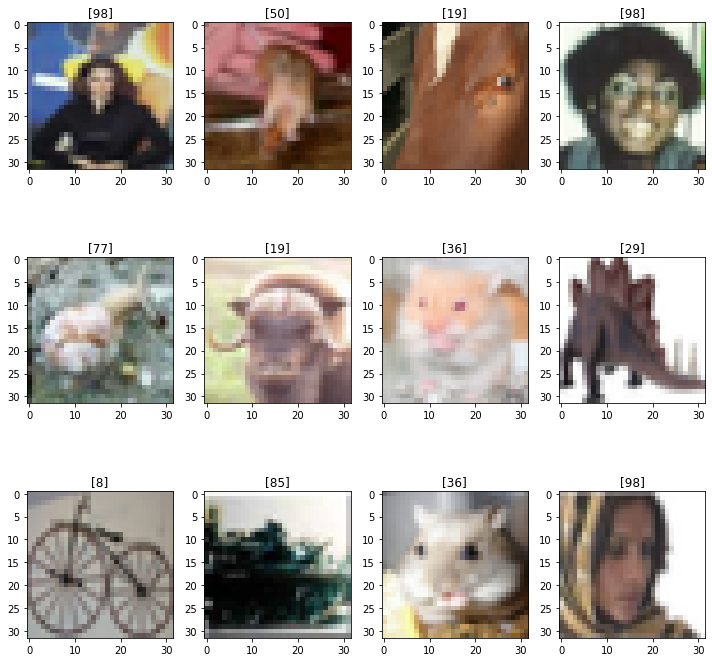

In [5]:
def show_samples(data, labels):
    plt.subplots(figsize=(10, 10))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        k = np.random.randint(0, data.shape[0])
        plt.title(labels[k])
        plt.imshow(data[k])
    plt.tight_layout()
    plt.show()
  
show_samples(train_images_og, train_labels_og)

## Preprocess Data
The labels will be transformed using one-hot encoding. This will create a vector of 0's with a 1 in the place of the correct label. This removes the ordered relationship that the classifier may misinterpret if left in. There is no ordered relationship between our classes and one-hot encoding removes the ordered relationship of the integer encoded labels. This is done with the use of ```keras.utils.to_categorical``` function. This will affect the shape of the labels as each label will be a vector of length 100 rather than a single integer. 

The images will need to be flattened. Previous coursework this was done before passing the images into the network, however in this report the rescaling layer will be used. This takes the image and rescales it to a float type in the range of 0-1 which the neural network will better understand. 

#### One-Hot Encode Labels


In [8]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels_og)
test_labels = to_categorical(test_labels_og)

print('\ttrain labels:', train_labels.shape)
print('\ttest labels:', test_labels.shape)

	train labels: (50000, 100)
	test labels: (10000, 100)


## Baseline Model

The last coursework was able to achieve an accuarcy of 25% on the cifar100 dataset while being limited to dense and dropout layers. The network consisted of 3 dense layers each with 1024 units with a final softmax output layer. A learning rate of 1e-4 and the Adam optimizer was used. This previous coursework model will serve as the baseline for this coursework. This will setup a good experiment to determine whether the use of convolutional layers and advanced computer vision techniques can improve upon the limited neural network constructed for the previous coursework. 



### Best model from CW1 to set baseline
Manually reshaping and rescaling the inputs for the previous coursework model is done to replicate results. When training new models for this coursework the use of the rescaling layer will be used.

#### Reshape Image Inputs for CW1 Network Baseline Model

In [9]:
train_images = train_images_og.reshape((50000, 32, 32, 3))
test_images = test_images_og.reshape((10000, 32, 32, 3))

In [8]:
train_images_flat = train_images_og.reshape((50000, 32*32*3)).astype('float32') / 255.
test_images_flat = test_images_og.reshape((10000, 32*32*3)).astype('float32') / 255.

In [ ]:
base_model = models.Sequential()
    
#first layer - needs input_shape
base_model.add(layers.Dense(1024, activation='relu', input_shape=(32 * 32 * 3, )))


# middle layers
base_model.add(layers.Dense(1024, activation='relu'))
base_model.add(layers.Dense(1024, activation='relu'))

# output layer
base_model.add(layers.Dense(100, activation='softmax'))

# 
base_model.compile(optimizer=keras.optimizers.Adam(0.0001),
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

base_model_history = base_model.fit(
    train_images_flat, 
    train_labels, 
    epochs=12, 
    verbose=2,
    validation_split=0.2
)


#### Chart Plotting Code

In [16]:
def plot_train_val_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_train_val_acc(history):
    plt.clf()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
        
    epochs = range(1, len(acc) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
        
    plt.plot(epochs, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def plot_val_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)
    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    # plt.plot(epochs_range, acc, label='Training Accuracy')
    # plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
 
    plt.plot(epochs_range, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, blue_dots, label='Training Loss')
    plt.plot(epochs_range, val_loss, solid_blue_line, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
  
def compare_loss(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['loss']), len(hist2.history['loss']))
    loss = hist1.history['loss'][:min_epochs]
    val_loss = hist1.history['val_loss'][:min_epochs]
    loss_drop = hist2.history['loss'][:min_epochs]
    val_loss_drop = hist2.history['val_loss'][:min_epochs]

    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, loss, blue_dots, label = f'{title1} Training Loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = f'{title1} Validation Loss')
    plt.plot(epochs, loss_drop, red_dots, label = f'{title2} Training Loss')
    plt.plot(epochs, val_loss_drop, solid_red_line, label = f'{title2} Validation Loss')
    # plt.title('Loss With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def compare_acc(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['accuracy']), len(hist2.history['accuracy']))
    acc = hist1.history['accuracy'][:min_epochs]
    val_acc = hist1.history['val_accuracy'][:min_epochs]
    acc_drop = hist2.history['accuracy'][:min_epochs]
    val_acc_drop = hist2.history['val_accuracy'][:min_epochs]
    
    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, acc, blue_dots, label = f'{title1} Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = f'{title1} Validation Accuracy')
    plt.plot(epochs, acc_drop, red_dots, label = f'{title2} Training Accuracy')
    plt.plot(epochs, val_acc_drop, solid_red_line, label = f'{title2} Validation Accuracy')
    # plt.title('Accuracy With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

#### Get Maximum Validation Accuracy and Minimum Validation Loss
Take the history from the models trained and return the maximum validation accuracy and the epoch at which it occurred as well as the minimum validation loss and the epoch at which it occurred.


In [13]:
def get_max_val_acc_epoch(history):
  val_acc = history.history['val_accuracy']
  max_val_acc = round(max(val_acc),5)*100
  max_epoch = np.argmax(val_acc)
  print('Max Validation Accuracy: ', max_val_acc, '%\t Num Epoch: ', max_epoch)
  return 
  
def get_min_val_loss_epoch(history):
  val_loss = history.history['val_loss']
  min_val_loss = round(min(val_loss),5)
  min_epoch = np.argmin(val_loss)
  print('Min Validation Loss: ', min_val_loss, '\t\t Num Epoch: ', min_epoch)
  return 
  
def get_max_acc_min_loss_epoch(history, model_name):
  print(model_name)
  get_max_val_acc_epoch(history)
  get_min_val_loss_epoch(history)


Base Model Validation Accuracy:  25.19 %


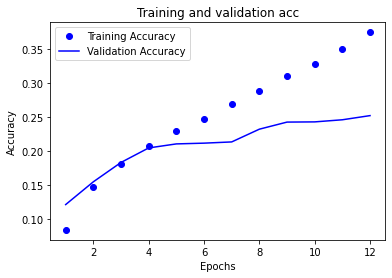

In [11]:
plot_train_val_acc(base_model_history)
print('Base Model Validation Accuracy: ', round(base_model_history.history['val_accuracy'][-1]*100,5),'%')


## Develop Model that Overfits
#### Small Base Convolutional Neural Network
The first model will exmine the effectiveness of a small base convolution neural network with a small number of filters. 
A standard window size of 3x3 with as stride of 1 will be used with no maxpooling layers included. 

In [10]:
def build_model_1():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(100, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_1 = build_model_1()

In [ ]:
model_1.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_1 = model_1.fit(
    train_images, 
    train_labels,
    epochs=10,
    verbose=2,
    validation_split=0.2
)

In [14]:
get_max_acc_min_loss_epoch(history_1, 'Model 1 - Base Convnet ')

Model 1 - Base Convnet 
Max Validation Accuracy:  29.770000000000003 %	 Num Epoch:  9
Min Validation Loss:  3.01884 		 Num Epoch:  7


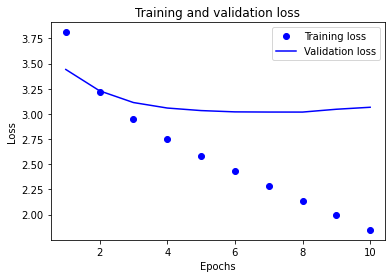

In [17]:
plot_train_val_loss(history_1)


Baseline convnet with 2 convolutional layers achieves a maximum validation accuracy of 29.77%. Already showing improvement over the baseline with no convolutional layers. 

#### Training and Validation Accuracy and Loss Plot Comparisions  


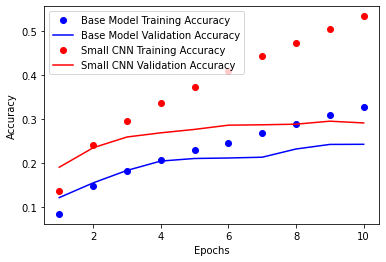

In [74]:
compare_acc(base_model_history, history_1, 'Base Model', 'Small CNN')

#### Add Max Pooling Layers to Conv2D layers
Maxpooling layers can help to reduce the number of paratemers a model can train. This can reduce overfitting. It also allows smaller windows in the final layers to be able to look at increasingly large windows of the image to help learn different features. A standard 2x2 window will be used effectively reducing the filter sizes in half. 

In [ ]:
def build_model_2():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    outputs = layers.Dense(100, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_2 = build_model_2()
model_2.summary()

In [ ]:
model_2.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
    
)

history_2 = model_2.fit(
    train_images, 
    train_labels,
    epochs=20,
    verbose=2,
    validation_split=0.2
)

In [75]:
get_max_acc_min_loss_epoch(history_2, 'Model 2')

Model 2
Max Validation Accuracy:  34.48 %	 Num Epoch:  18
Min Validation Loss:  2.74917 		 Num Epoch:  18


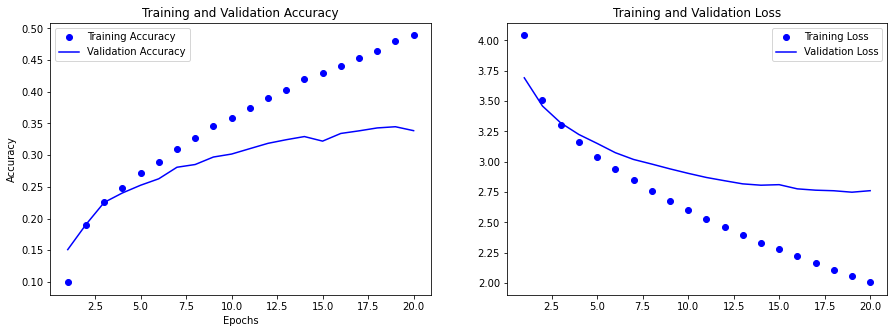

In [76]:
plot_val_loss_acc(history_2)

The addition of max pooling layers results in the model achievening a higher validation accuracy and lower training loss. The model takes more epochs to begin overfitting. 

### Add Dense Layer (3)
The addition of a dense layer after the convolutional layers can be used to aid the network in learning more about the image patterns that have been discovered through the convolutional filters. 

In [20]:
def build_model_3():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_3 = build_model_3()

In [ ]:
model_3.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_3 = model_3.fit(
    train_images, 
    train_labels,
    epochs=50,
    verbose=2,
    validation_split=0.2
)

Model 3
Max Validation Accuracy:  36.5 %	 Num Epoch:  35
Min Validation Loss:  2.6865 		 Num Epoch:  26


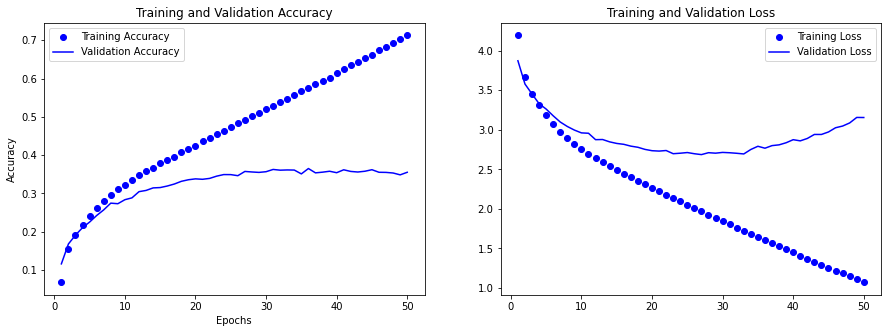

In [82]:
get_max_acc_min_loss_epoch(history_3, 'Model 3')
plot_val_loss_acc(history_3)

The addition of a single dense layer with 128 units at the end of the convolutional layers increases the validation accuracy to 36.5% from 34.5%. 

### Add Conv2D and MaxPooling Layer (4)
Test whether the addition of another convolutional and max pooling layer is needed to learn more patterns. 

In [ ]:
def build_model_4():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.Flatten()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_4 = build_model_4()
model_4.summary()

In [ ]:
model_4.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_4 = model_4.fit(
    train_images, 
    train_labels,
    epochs=30,
    verbose=2,
    validation_split=0.2
)

Model 4: 4 Conv2D Layers
Max Validation Accuracy:  34.9 %	 Num Epoch:  28
Min Validation Loss:  2.65042 		 Num Epoch:  28


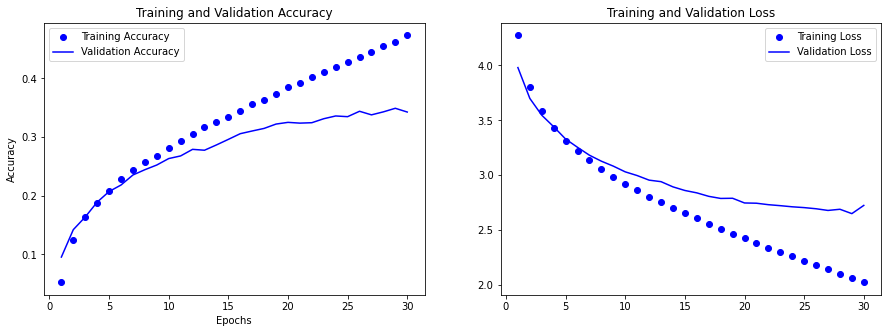

In [92]:
get_max_acc_min_loss_epoch(history_4, 'Model 4: 4 Conv2D Layers')
plot_val_loss_acc(history_4)

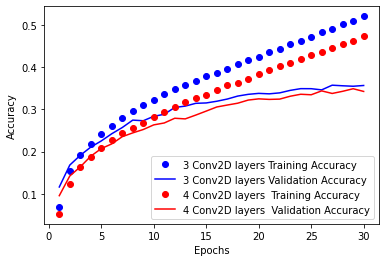

In [97]:
compare_acc(history_3, history_4, '3 Conv2D layers', '4 Conv2D layers ')


The model begins overfitting at 28 epochs and reaches a maximum accuarcy of 34.9%, showing that 3 convolutional and max pooling layers performs better than 4. 


### Kernal size 4 (5)

Increasing the size of the windows used in the convolutional layer has the effect of the layers learning larger patterns. 

In [ ]:
def build_model_5():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=16, kernel_size=4, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=32, kernel_size=4, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=4, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_5 = build_model_5()
model_5.summary()

In [ ]:
model_5.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_5 = model_5.fit(
    train_images, 
    train_labels,
    epochs=30,
    verbose=2,
    validation_split=0.2
)

Model 5: Conv2D 4x4 Kernal
Max Validation Accuracy:  35.75 %	 Num Epoch:  13
Min Validation Loss:  2.69232 		 Num Epoch:  5


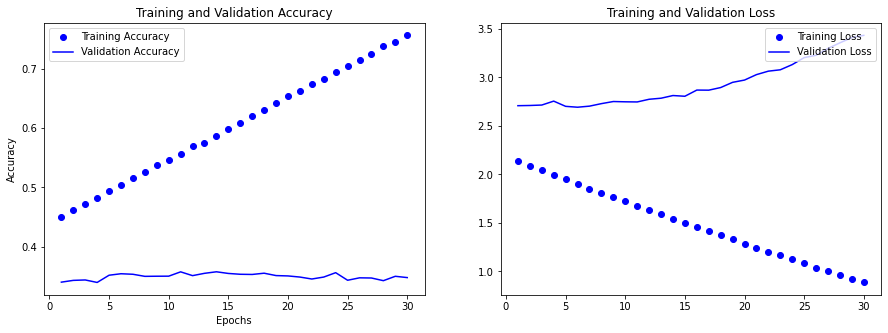

In [100]:
get_max_acc_min_loss_epoch(history_5, 'Model 5: Conv2D 4x4 Kernal')
plot_val_loss_acc(history_5)


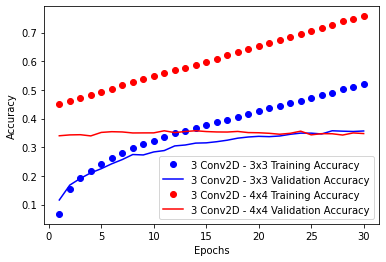

In [96]:
compare_acc(history_3, history_5, '3 Conv2D - 3x3', '3 Conv2D - 4x4')


Not an ideal learning pattern and similar accuracy to 3x3 so use the 3x3 window size for future models. The window size of 4x4 may be too large for a smaller image size of only 32x32. 

### Higher and Lower Learning Rates (6,7)

Experiment to determine the optimal learning rate. A learning rate that is too high could miss a proper fit during the gradient descent algorithm. A learning rate that is too low could be too slow to learn and result in a stalled out learning process.

In [ ]:
model_6 = build_model_3()

model_6.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_6 = model_6.fit(
    train_images, 
    train_labels,
    epochs=30,
    verbose=2,
    validation_split=0.2
)

Model 6: Learning Rate 1e-3
Max Validation Accuracy:  36.18 %	 Num Epoch:  8
Min Validation Loss:  2.60868 		 Num Epoch:  5


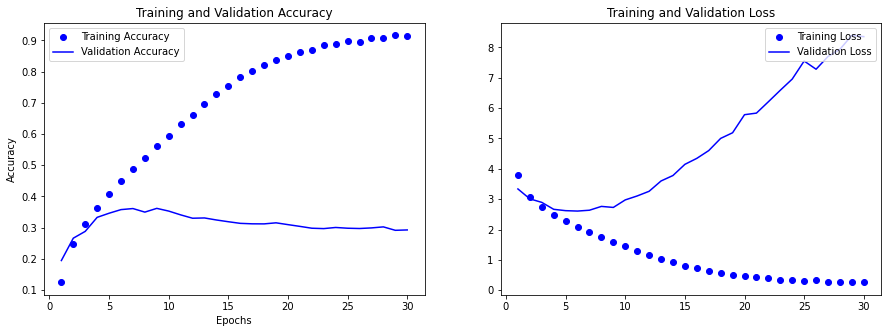

In [102]:
get_max_acc_min_loss_epoch(history_6, 'Model 6: Learning Rate 1e-3')
plot_val_loss_acc(history_6)

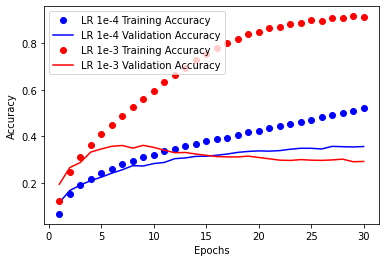

In [103]:
compare_acc(history_3, history_6, 'LR 1e-4', 'LR 1e-3')


The higher learning rate appears to reach its peak accuracy too soon, this is the risk of increasing the learning rate. It skips over the optimum fit and begins to overfit much to soon. 

In [ ]:
model_7 = build_model_3()

model_7.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_7 = model_7.fit(
    train_images, 
    train_labels,
    epochs=50,
    verbose=2,
    validation_split=0.2
)

Model 7: Learning Rate 1e-5
Max Validation Accuracy:  22.68 %	 Num Epoch:  49
Min Validation Loss:  3.30489 		 Num Epoch:  49


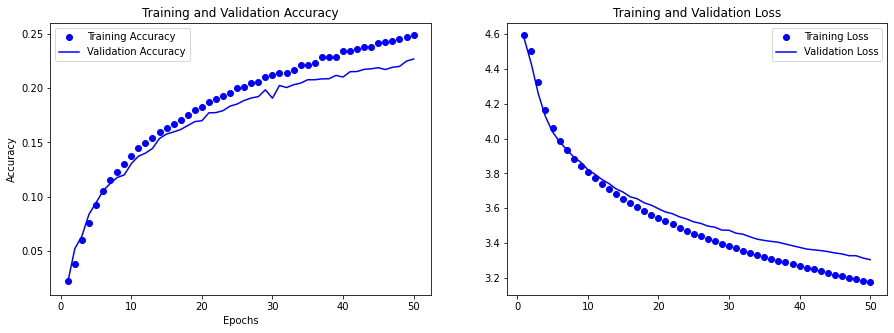

In [99]:
get_max_acc_min_loss_epoch(history_7, 'Model 7: Learning Rate 1e-5')
plot_val_loss_acc(history_7)

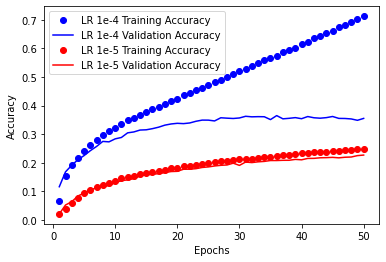

In [33]:
compare_acc(history_3, history_7, 'LR 1e-4', 'LR 1e-5')

Learning rate of 1e-4 much better than 1e-5 even after running for 50 epochs. Evident validation accuracy for 1e-5 has stalled out. A learning rate of 1e-4 proved to be the best option. 

### Increase Starting Filter Sizes (8)

Increasing the amount of filters used in each convolutional layer could allow the network to learn more patterns in the data and increase overall accuracy. However, too many and this could lead to overfitting. 

In [ ]:
def build_model_8():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_8 = build_model_8()
model_8.summary()


In [ ]:
model_8.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_8 = model_8.fit(
    train_images, 
    train_labels,
    epochs=50,
    verbose=2,
    validation_split=0.2
)

Model 8: Layer 1 64 Filters
Max Validation Accuracy:  36.3 %	 Num Epoch:  26
Min Validation Loss:  2.67473 		 Num Epoch:  18


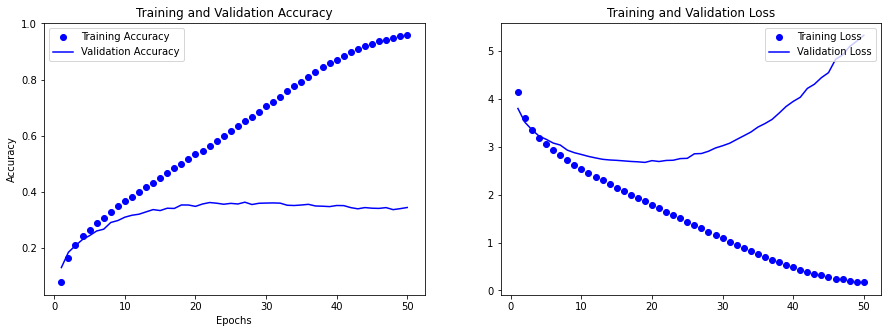

In [104]:
get_max_acc_min_loss_epoch(history_8, 'Model 8: Layer 1 64 Filters')
plot_val_loss_acc(history_8)

Increasing the starting convolutional layer filters paramater to 

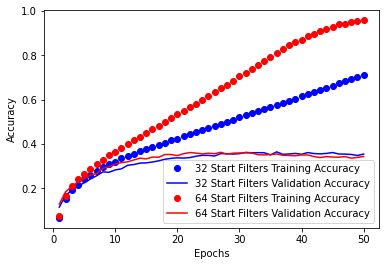

In [38]:
compare_acc(history_3, history_8, '32 Start Filters','64 Start Filters')

**64 starting units better than 32**

In [ ]:
def build_model_8b():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_8b = build_model_8b()
model_8b.summary()

In [ ]:
model_8b.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_8b = model_8b.fit(
    train_images, 
    train_labels,
    epochs=50,
    verbose=2,
    validation_split=0.2
)

Model 8b: Layer 1 128 Filters
Max Validation Accuracy:  38.79 %	 Num Epoch:  11
Min Validation Loss:  2.56436 		 Num Epoch:  7


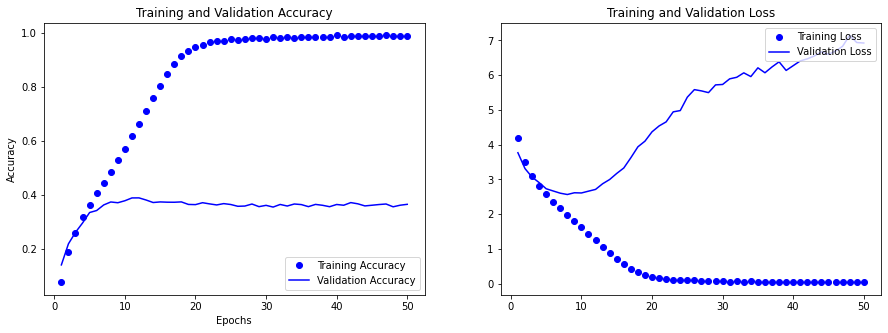

In [105]:
get_max_acc_min_loss_epoch(history_8b, 'Model 8b: Layer 1 128 Filters')
plot_val_loss_acc(history_8b)

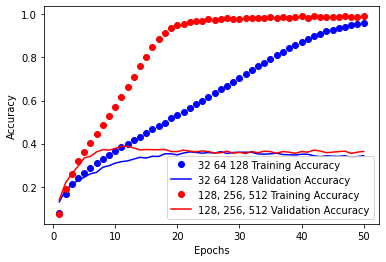

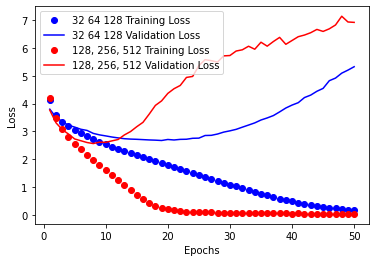

In [41]:
compare_acc(history_8, history_8b, '32 64 128','128, 256, 512')
compare_loss(history_8, history_8b, '32 64 128','128, 256, 512')

Higher units better, stick with 128, 256, 512

### Remove Padding (9)


In [ ]:
def build_model_9():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_9 = build_model_9()
model_9.summary()

In [ ]:
model_9.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_9 = model_9.fit(
    train_images, 
    train_labels,
    epochs=50,
    verbose=2,
    validation_split=0.2
)

Model 9: No Padding
Max Validation Accuracy:  36.97 %	 Num Epoch:  38
Min Validation Loss:  2.66341 		 Num Epoch:  24


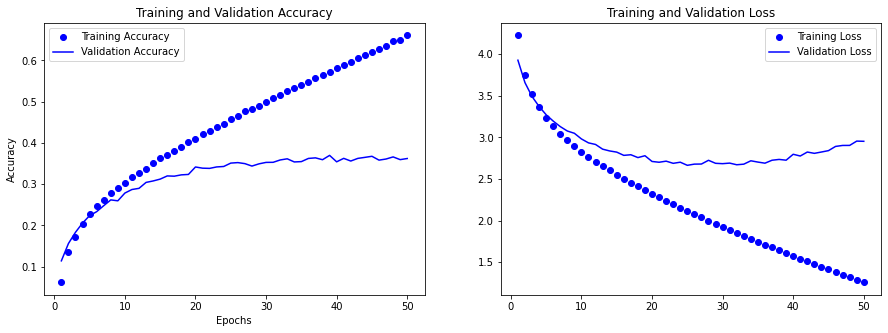

In [106]:
get_max_acc_min_loss_epoch(history_9, 'Model 9: No Padding')
plot_val_loss_acc(history_9)

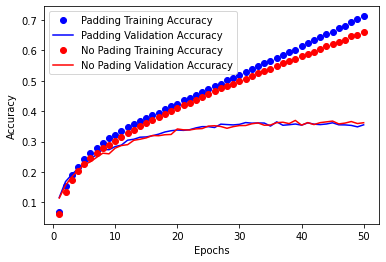

In [44]:
compare_acc(history_3, history_9, 'Padding','No Pading')

Use of padding is more accurate and has lower loss so keep padding. 

Best Model is currently 8b. Compare with that going forward. 

### 4 Conv2D Layers with 8b Base (10)

In [ ]:
def build_model_10():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_10_4_Conv2d_layers')
    return model

model_10 = build_model_10()
model_10.summary()

In [ ]:
model_10.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_10 = model_10.fit(
    train_images, 
    train_labels,
    epochs=50,
    verbose=2,
    validation_split=0.2
)

Model 10: 4 Conv2D
Max Validation Accuracy:  38.940000000000005 %	 Num Epoch:  9
Min Validation Loss:  2.55983 		 Num Epoch:  6
Model 8b: 3 Conv2D
Max Validation Accuracy:  38.79 %	 Num Epoch:  11
Min Validation Loss:  2.56436 		 Num Epoch:  7


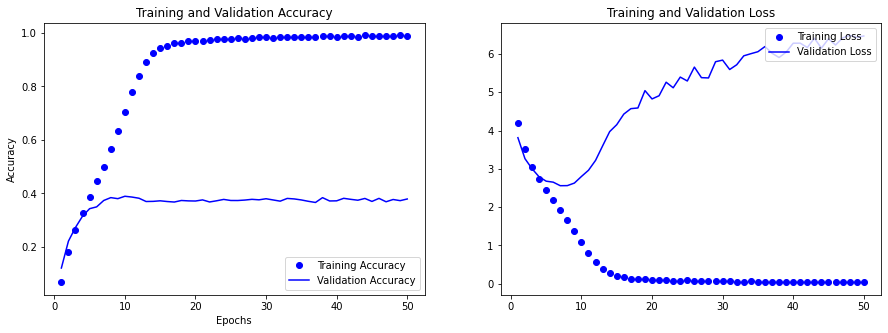

In [113]:
get_max_acc_min_loss_epoch(history_10, 'Model 10: 4 Conv2D')
get_max_acc_min_loss_epoch(history_8b, 'Model 8b: 3 Conv2D')
plot_val_loss_acc(history_10)

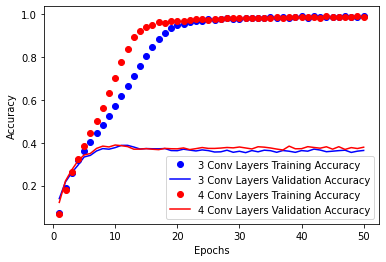

In [112]:
compare_acc(history_8b, history_10, '3 Conv Layers','4 Conv Layers')

4 layers more accurate so use that going forward.

### Data Augmentation (Aug)

Paper references:
- Keras' ImageDataGenerator()
- shear, zoom, horizontal flip, featurewise center, width shift
tuned to extend dataset

In [ ]:
data_augmentation = keras.Sequential([
      layers.RandomFlip('horizontal_and_vertical', input_shape=(32,32,3)),
      layers.RandomRotation(0.2),
      layers.RandomZoom(0.2)
])

def build_model_augment_1():
    inputs = keras.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs)

    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='model_augment_1')
    return model

model_augment_1 = build_model_augment_1()
model_augment_1.summary()

In [ ]:
model_augment_1.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_augment_1 = model_augment_1.fit(
    train_images, 
    train_labels,
    epochs=25,
    verbose=2,
    validation_split=0.2
)

Model: Augmentation
Max Validation Accuracy:  38.37 %	 Num Epoch:  9
Min Validation Loss:  2.54802 		 Num Epoch:  7
Model: No Augmentation
Max Validation Accuracy:  38.940000000000005 %	 Num Epoch:  9
Min Validation Loss:  2.55983 		 Num Epoch:  6


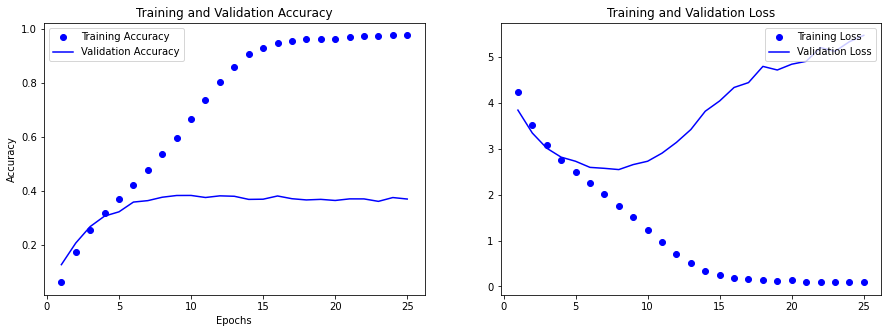

In [119]:
get_max_acc_min_loss_epoch(history_augment_1, 'Model: Augmentation')
get_max_acc_min_loss_epoch(history_10, 'Model: No Augmentation')
plot_val_loss_acc(history_augment_1)

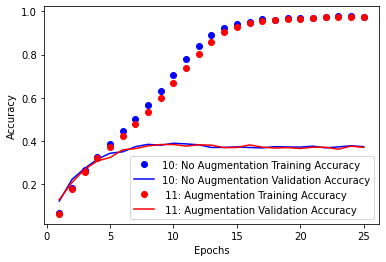

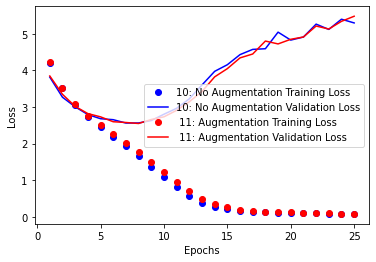

In [117]:
compare_acc(history_10, history_augment_1, '10: No Augmentation',' Augmentation')
compare_loss(history_10, history_augment_1, '10: No Augmentation',' Augmentation')


Image Augmentation does not improve accuracy however slightly lower loss but overall no change and more intensive to train so stick with simpler model 10.

### More Dense Layers w. Dropout (11)

In [ ]:
def build_model_11():
    inputs = keras.Input(shape=(32, 32, 3))
    
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu", padding='same')(x)

    x = layers.Flatten()(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)


    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_Augmentation_W_Dropout')
    return model

model_11 = build_model_11()
model_11.summary()

In [14]:
model_11.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_11 = model_11.fit(
    train_images, 
    train_labels,
    epochs=30,
    verbose=2,
    validation_split=0.2
)

Epoch 1/30
1250/1250 - 7s - loss: 4.4203 - accuracy: 0.0291 - val_loss: 4.1683 - val_accuracy: 0.0610 - 7s/epoch - 5ms/step
Epoch 2/30
1250/1250 - 6s - loss: 4.0511 - accuracy: 0.0674 - val_loss: 3.7177 - val_accuracy: 0.1335 - 6s/epoch - 5ms/step
Epoch 3/30
1250/1250 - 6s - loss: 3.7133 - accuracy: 0.1226 - val_loss: 3.3330 - val_accuracy: 0.1933 - 6s/epoch - 5ms/step
Epoch 4/30
1250/1250 - 6s - loss: 3.4405 - accuracy: 0.1659 - val_loss: 3.1216 - val_accuracy: 0.2450 - 6s/epoch - 5ms/step
Epoch 5/30
1250/1250 - 6s - loss: 3.1975 - accuracy: 0.2100 - val_loss: 2.9264 - val_accuracy: 0.2820 - 6s/epoch - 5ms/step
Epoch 6/30
1250/1250 - 6s - loss: 2.9844 - accuracy: 0.2497 - val_loss: 2.6872 - val_accuracy: 0.3236 - 6s/epoch - 5ms/step
Epoch 7/30
1250/1250 - 6s - loss: 2.7816 - accuracy: 0.2899 - val_loss: 2.5807 - val_accuracy: 0.3511 - 6s/epoch - 5ms/step
Epoch 8/30
1250/1250 - 6s - loss: 2.5895 - accuracy: 0.3313 - val_loss: 2.4306 - val_accuracy: 0.3808 - 6s/epoch - 5ms/step
Epoch 9/

In [ ]:
get_max_acc_min_loss_epoch(history_11, 'Model 11: Dense Layers w. Dropout')
plot_val_loss_acc(history_11)

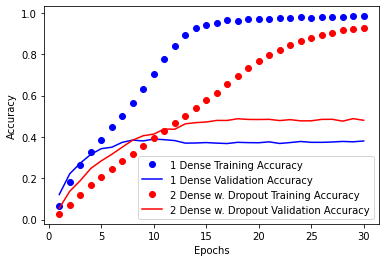

In [127]:
compare_acc(history_10, history_11, '1 Dense','2 Dense w. Dropout')

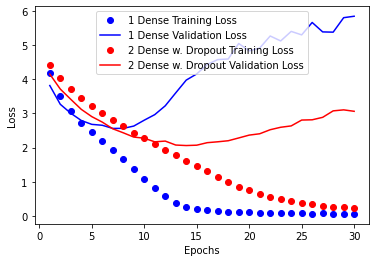

In [128]:
compare_loss(history_10, history_11, '1 Dense','2 Dense w. Dropout')

Adding dropout layers and more dense layers large improvement

### Increase Dense Units (12)

In [ ]:
def build_model_12():
    inputs = keras.Input(shape=(32, 32, 3))
    
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu", padding='same')(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)


    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_12_2_Dense_w_dropout')
    return model

model_12 = build_model_12()
model_12.summary()

In [ ]:
model_12.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_12 = model_12.fit(
    train_images, 
    train_labels,
    epochs=30,
    verbose=2,
    validation_split=0.2
)

Model 12: 2 Dense Layers 1024 - 1024
Max Validation Accuracy:  49.53 %	 Num Epoch:  18
Min Validation Loss:  2.04545 		 Num Epoch:  10
Model 11: 2 Dense Layers 512 - 512
Max Validation Accuracy:  47.68 %	 Num Epoch:  24
Min Validation Loss:  2.11455 		 Num Epoch:  14


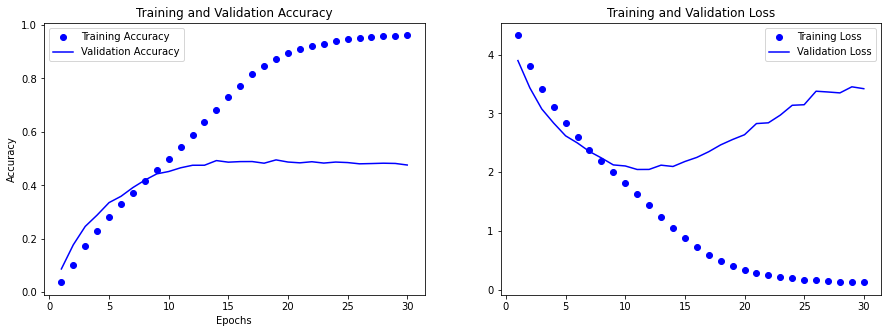

In [15]:
get_max_acc_min_loss_epoch(history_12, 'Model 12: 2 Dense Layers 1024 - 1024')
get_max_acc_min_loss_epoch(history_11, 'Model 11: 2 Dense Layers 512 - 512')
plot_val_loss_acc(history_12)

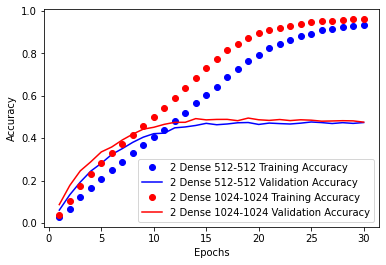

In [16]:
compare_acc(history_11, history_12, '2 Dense 512-512','2 Dense 1024-1024')

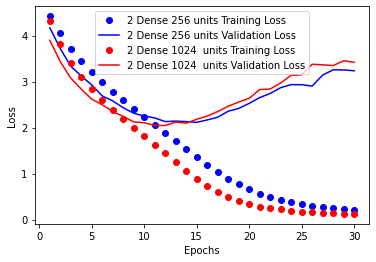

In [17]:
compare_loss(history_11, history_12, '2 Dense 256 units','2 Dense 1024  units')

Model 12 Better: 
Bigger units means lower loss and higher accuracy 
sooner at 12 epochs. 

### Max Pooling Layer to last Conv2d Layer (13)

In [ ]:
def build_model_13():
    inputs = keras.Input(shape=(32, 32, 3))
    
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)


    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_12_2_Dense_w_dropout')
    return model


model_13 = build_model_13()
model_13.summary()

In [ ]:
model_13.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_13 = model_13.fit(
    train_images, 
    train_labels,
    epochs=30,
    verbose=2,
    validation_split=0.2
)

Model 13: 4 Max Pooling Layers
Max Validation Accuracy:  47.52 %	 Num Epoch:  14
Min Validation Loss:  2.11453 		 Num Epoch:  10
Model 12: 3 Max Pooling Layers
Max Validation Accuracy:  48.93 %	 Num Epoch:  23
Min Validation Loss:  2.04836 		 Num Epoch:  12


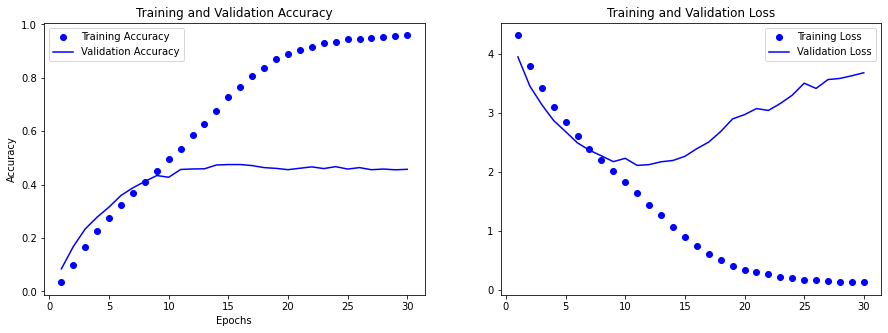

In [138]:
get_max_acc_min_loss_epoch(history_13, 'Model 13: 4 Max Pooling Layers')
get_max_acc_min_loss_epoch(history_12, 'Model 12: 3 Max Pooling Layers')
plot_val_loss_acc(history_13)

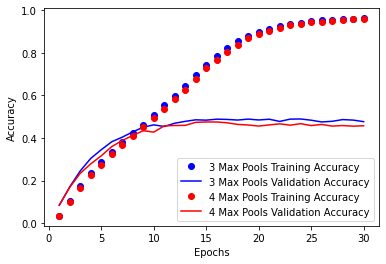

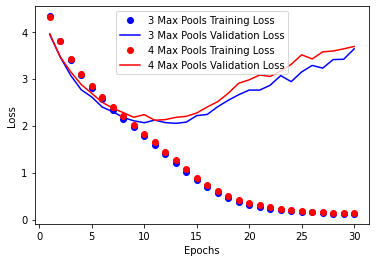

In [137]:
compare_acc(history_12, history_13, '3 Max Pools','4 Max Pools')
compare_loss(history_12, history_13, '3 Max Pools','4 Max Pools')

Model 13 had worse results than model 12.

### Dropout After Input Layer (14) 
Mentioned in paper, dropout 0.2



In [ ]:
def build_model_14():
    inputs = keras.Input(shape=(32, 32, 3))
    
    x = layers.Rescaling(1./255)(inputs) 
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu", padding='same')(x)

    
    x = layers.Flatten()(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)


    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_14_Early_Dropout')
    return model


model_14 = build_model_14()
model_14.summary()

In [ ]:
model_14.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_14 = model_14.fit(
    train_images, 
    train_labels,
    epochs=30,
    verbose=2,
    validation_split=0.2
)

Model 14: Dropout (0.2) After Input
Max Validation Accuracy:  38.15 %	 Num Epoch:  23
Min Validation Loss:  2.62106 		 Num Epoch:  14


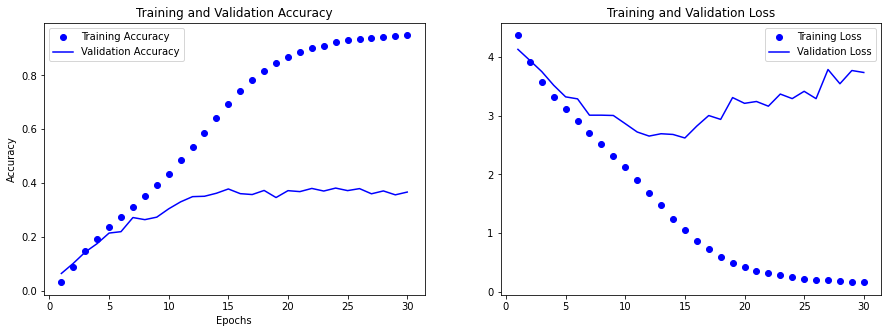

In [148]:
get_max_acc_min_loss_epoch(history_14, 'Model 14: Dropout (0.2) After Input')
plot_val_loss_acc(history_14)

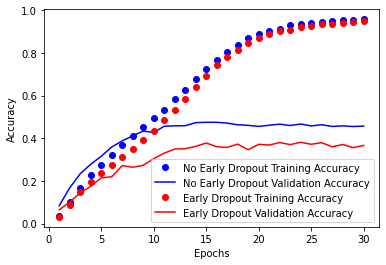

In [149]:
compare_acc(history_13, history_14, 'No Early Dropout','Early Dropout')



### Batch Normalization (15)

Section 9.3.3 of text


In [ ]:
def build_model_15():
    inputs = keras.Input(shape=(32, 32, 3))
    
    x = layers.Rescaling(1./255)(inputs) 
    
    x = layers.Conv2D(filters=128, kernel_size=3, use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=512, kernel_size=3, use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(filters=1024, kernel_size=3, use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
        
    x = layers.Flatten()(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)


    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_15_Batch_Normalization')
    return model

model_15 = build_model_15()
model_15.summary()

In [ ]:
model_15.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_15 = model_15.fit(
    train_images, 
    train_labels,
    epochs=30,
    verbose=2,
    validation_split=0.2
)

Model 15: Batch Normalization
Max Validation Accuracy:  44.39 %	 Num Epoch:  28
Min Validation Loss:  2.22105 		 Num Epoch:  17
Model 12: No Batch Normalization
Max Validation Accuracy:  48.93 %	 Num Epoch:  23
Min Validation Loss:  2.04836 		 Num Epoch:  12


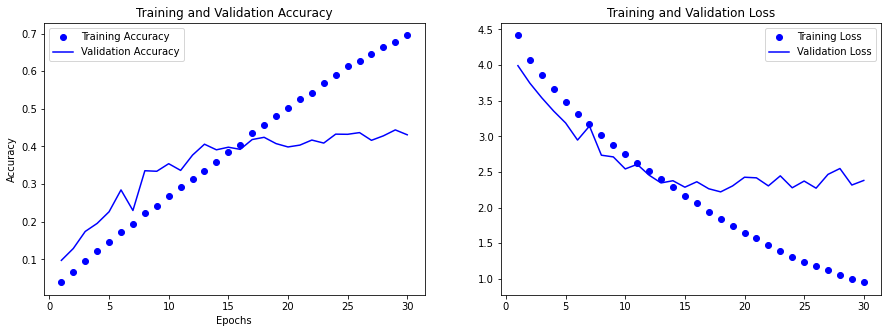

In [152]:
get_max_acc_min_loss_epoch(history_15, 'Model 15: Batch Normalization')
get_max_acc_min_loss_epoch(history_12, 'Model 12: No Batch Normalization')
plot_val_loss_acc(history_15)

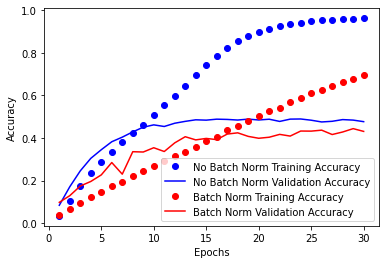

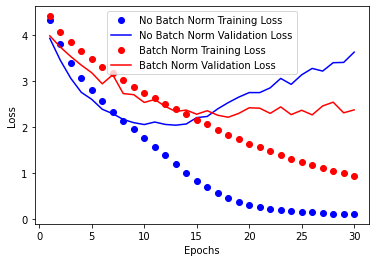

In [153]:
compare_acc(history_12, history_15, 'No Batch Norm','Batch Norm')
compare_loss(history_12, history_15, 'No Batch Norm','Batch Norm')

Batch Normalization did not improve model

### Residuals (16)
Section 9.3.2 of text

In [ ]:
def build_model_16():
    inputs = keras.Input(shape=(32, 32, 3))
    
    x = layers.Rescaling(1./255)(inputs) 
    
    def residual_block(x, filters, pooling=False): 
      residual = x
      x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
      x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
      if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual) 
      elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual) 
      x = layers.add([x, residual])
      return x
    
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 512, pooling=True)
    x = residual_block(x, 1024, pooling=True)

    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_16_Residuals')
    return model

model_16 = build_model_16()
model_16.summary()

In [ ]:
model_16.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_16 = model_16.fit(
    train_images, 
    train_labels,
    epochs=30,
    verbose=2,
    validation_split=0.2
)

Model 16: Residuals
Max Validation Accuracy:  47.42 %	 Num Epoch:  9
Min Validation Loss:  2.1047 		 Num Epoch:  5
Model 12: No Residuals
Max Validation Accuracy:  48.93 %	 Num Epoch:  23
Min Validation Loss:  2.04836 		 Num Epoch:  12


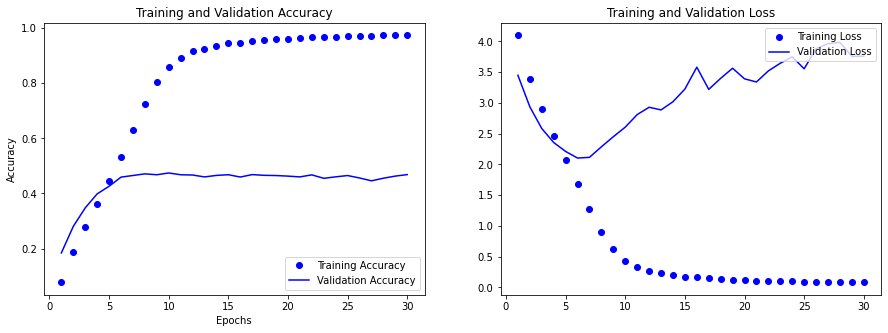

In [159]:
get_max_acc_min_loss_epoch(history_16, 'Model 16: Residuals')
get_max_acc_min_loss_epoch(history_12, 'Model 12: No Residuals')
plot_val_loss_acc(history_16)

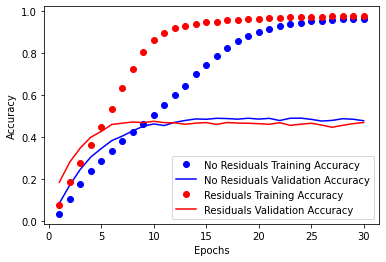

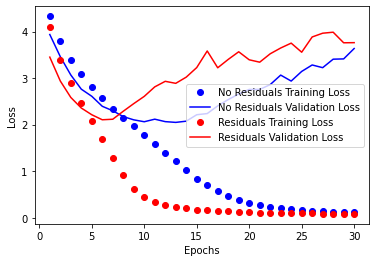

In [160]:
compare_acc(history_12, history_16, 'No Residuals','Residuals')
compare_loss(history_12, history_16, 'No Residuals','Residuals')

Residuals don't improve model.

### Depthwise Separable Convolution Layers (17)
Section 9.3.4  

In [ ]:
def build_model_17():
    inputs = keras.Input(shape=(32, 32, 3))
    
    x = layers.Rescaling(1./255)(inputs) 
    # need a conv2d layer to begin to handle color
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)

    def residual_block(x, filters, pooling=False): 
      residual = x
      x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
      x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
      if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual) 
      elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual) 
      x = layers.add([x, residual])
      return x
    
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 512, pooling=True)
    x = residual_block(x, 1024, pooling = False)

    x = layers.Flatten()(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)


    outputs = layers.Dense(100, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Model_16_Residuals')
    
    return model


model_17 = build_model_17()
model_17.summary()

In [ ]:
model_17.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_17 = model_17.fit(
    train_images, 
    train_labels,
    epochs=30,
    verbose=2,
    validation_split=0.2
)

Model 17: Seperable Conv2d
Max Validation Accuracy:  42.04 %	 Num Epoch:  27
Min Validation Loss:  2.36901 		 Num Epoch:  26
Model 12: Conv2d
Max Validation Accuracy:  48.93 %	 Num Epoch:  23
Min Validation Loss:  2.04836 		 Num Epoch:  12


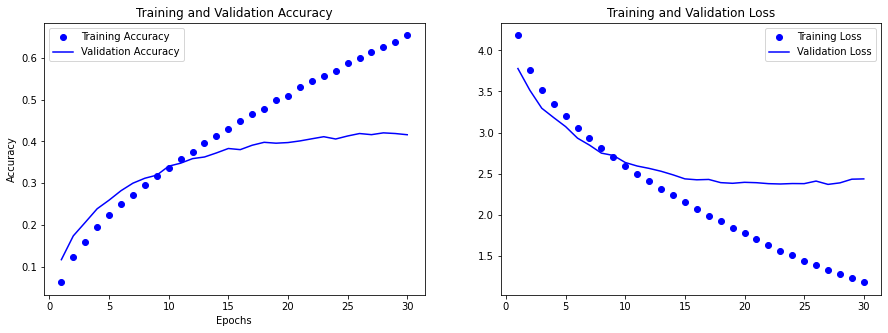

In [167]:
get_max_acc_min_loss_epoch(history_17, 'Model 17: Seperable Conv2d')
get_max_acc_min_loss_epoch(history_12, 'Model 12: Conv2d')
plot_val_loss_acc(history_17)

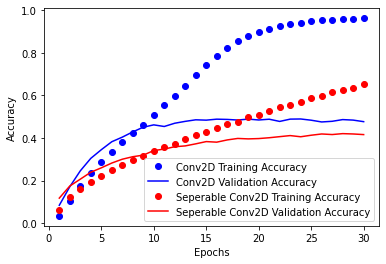

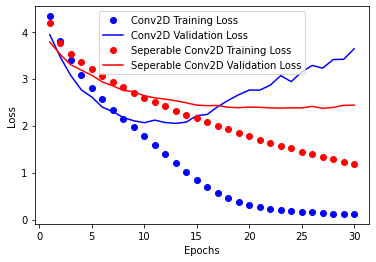

In [168]:
compare_acc(history_12, history_17, 'Conv2D','Seperable Conv2D')
compare_loss(history_12, history_17, 'Conv2D','Seperable Conv2D')

Doesn't make it any lower after longer training so model 12 still best model. 

## Pretrained model

- Weights: specifies the weight checkpoint from which to initialize the model 
- ```include_top```: including or not the densely connected classifier on top of the network. By default this densely connected classifier corresponds to the 1000 classes from ImageNet. Because we intend to use our own densely connected classifier don't include

### Base Pretrained VGG16 (18, 19)

In [ ]:
base_model_vgg16 = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape = (32,32,3),
    include_top=False
)

def build_ft_model_1():
    
    base_model_vgg16.trainable=False

    inputs = keras.Input(shape=(32, 32, 3))
   
    x = keras.applications.vgg16.preprocess_input(inputs)

    x = base_model_vgg16(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(100, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='FT_Model')

    return model

ft_model_1 = build_ft_model_1()
ft_model_1.summary()



In [ ]:
ft_model_1.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_ft_1 = ft_model_1.fit(
    train_images, 
    train_labels,
    epochs=50,
    verbose=2,
    validation_split=0.2
)

In [55]:
ft_model_2 = build_ft_model_1()

base_model_vgg16.trainable = True
for layer in base_model_vgg16.layers[:-4]:
 layer.trainable = False

ft_model_2.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_ft_2 = ft_model_2.fit(
    train_images, 
    train_labels,
    epochs=40,
    verbose=2,
    validation_split=0.2
)


Model 18: Vgg16
Max Validation Accuracy:  42.199999999999996 %	 Num Epoch:  47
Min Validation Loss:  2.24404 		 Num Epoch:  48
Model 12: Self Trained
Max Validation Accuracy:  49.53 %	 Num Epoch:  18
Min Validation Loss:  2.04545 		 Num Epoch:  10


Model 18: Vgg16
Max Validation Accuracy:  42.199999999999996 %	 Num Epoch:  47
Min Validation Loss:  2.24404 		 Num Epoch:  48
Model 12: Self Trained
Max Validation Accuracy:  49.53 %	 Num Epoch:  18
Min Validation Loss:  2.04545 		 Num Epoch:  10


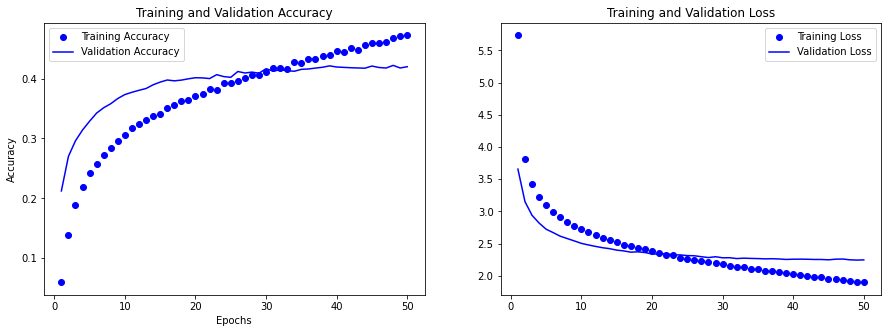

In [60]:
get_max_acc_min_loss_epoch(history_ft_1, 'Model 18: Vgg16')
get_max_acc_min_loss_epoch(history_12, 'Model 12: Self Trained')
plot_val_loss_acc(history_ft_1)

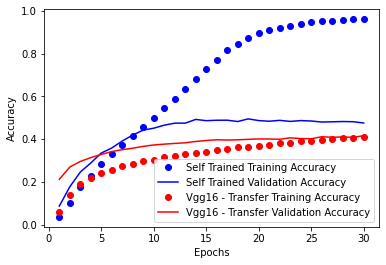

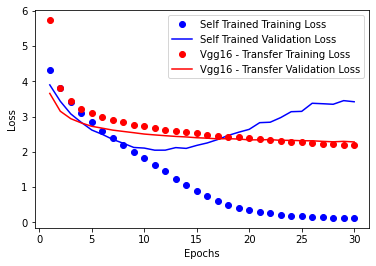

In [57]:
compare_acc(history_12, history_ft_1, 'Self Trained', 'Vgg16 - Transfer')
compare_loss(history_12, history_ft_1, 'Self Trained', 'Vgg16 - Transfer')

### Unfreeze last 3 layers and Lower Learning Rate
Fine tune model but opening last 3 layers but lower learning rate so no major adjustments made.


In [ ]:
ft_model_2 = build_ft_model_1()


base_model_vgg16.trainable = True
for layer in base_model_vgg16.layers[:-4]:
 layer.trainable = False


ft_model_2.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_ft_2 = ft_model_2.fit(
    train_images, 
    train_labels,
    epochs=50,
    verbose=2,
    validation_split=0.2
)

Model 19: Vgg16 FT
Max Validation Accuracy:  46.45 %	 Num Epoch:  47
Min Validation Loss:  2.39385 		 Num Epoch:  25
Model 18: Vgg16
Max Validation Accuracy:  42.199999999999996 %	 Num Epoch:  47
Min Validation Loss:  2.24404 		 Num Epoch:  48


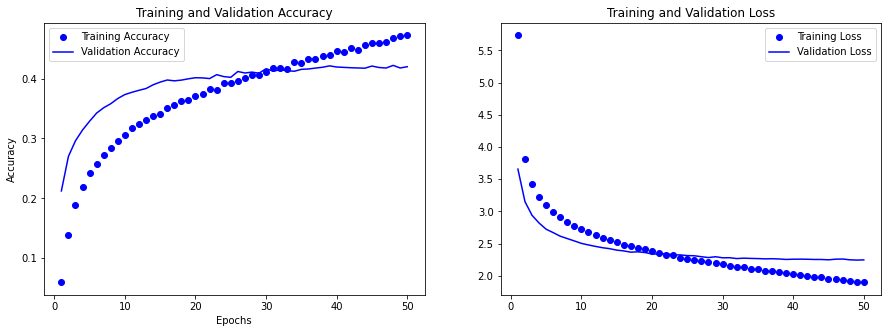

In [63]:
get_max_acc_min_loss_epoch(history_ft_2, 'Model 19: Vgg16 FT')
get_max_acc_min_loss_epoch(history_ft_1, 'Model 18: Vgg16')
plot_val_loss_acc(history_ft_1)

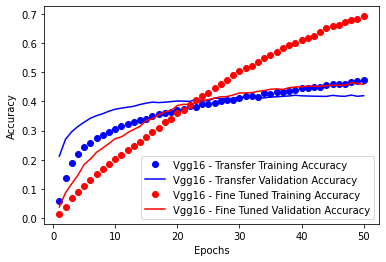

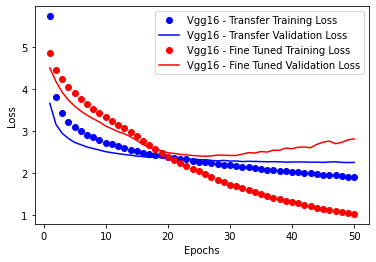

In [64]:
compare_acc(history_ft_1, history_ft_2, 'Vgg16 - Transfer', 'Vgg16 - Fine Tuned')
compare_loss(history_ft_1, history_ft_2, 'Vgg16 - Transfer', 'Vgg16 - Fine Tuned')

Custom model still better

### Unfreeze model

In [65]:
base_model_vgg16.trainable = True
ft_model_2.summary()

Model: "FT_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem_17  (None, 32, 32, 3)        0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_17 (TFOpLamb  (None, 32, 32, 3)        0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_17  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                          

In [ ]:
ft_model_2.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

history_ft_3 = ft_model_2.fit(
    train_images, 
    train_labels,
    epochs=50,
    verbose=2,
    validation_split=0.2
)


Model 19: Vgg16 FT 2
Max Validation Accuracy:  53.54 %	 Num Epoch:  49
Min Validation Loss:  2.60359 		 Num Epoch:  12
Model 18: Vgg16 FT 1
Max Validation Accuracy:  46.45 %	 Num Epoch:  47
Min Validation Loss:  2.39385 		 Num Epoch:  25


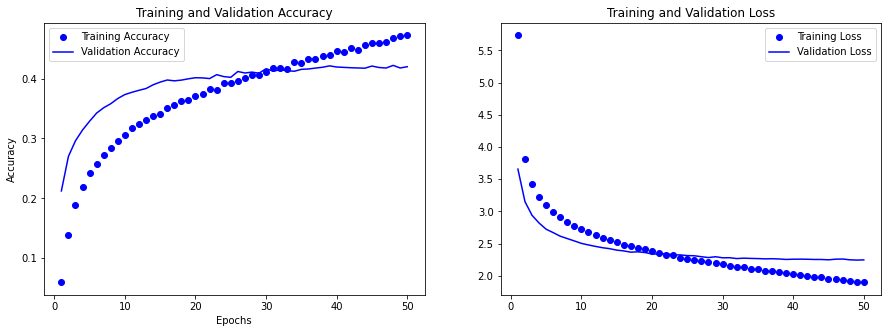

In [67]:
get_max_acc_min_loss_epoch(history_ft_3, 'Model 19: Vgg16 FT 2')
get_max_acc_min_loss_epoch(history_ft_2, 'Model 18: Vgg16 FT 1')
plot_val_loss_acc(history_ft_1)

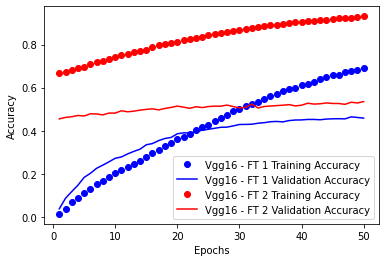

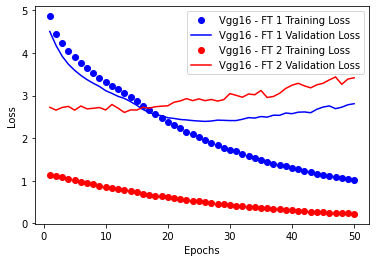

In [68]:
compare_acc(history_ft_2, history_ft_3, 'Vgg16 - FT 1', 'Vgg16 - FT 2')
compare_loss(history_ft_2, history_ft_3, 'Vgg16 - FT 1', 'Vgg16 - FT 2')

Overfitting after 12 epochs. 

## Final Model

In [73]:
ft_model_2.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)


### Final Pre-Trained Model

Train on all data then test

In [ ]:
history_final = ft_model_2.fit(
  train_images, 
  train_labels,
  epochs=12,
  verbose=2,
)


In [75]:
final_results_pretrained = ft_model_2.evaluate(test_images, test_labels)
print('Final Pre-trained Model Accuracy: ', round(final_results_pretrained[1]*100,2),'%')
print('Final Pre-trained Model Loss: ', final_results_pretrained[0])

313/313 [==============================] - 2s 5ms/step - loss: 3.0838 - accuracy: 0.5536
Final Pre-trained Model Accuracy:  55.36 %
Final Pre-trained Model Loss:  3.083804130554199


#### Evaluate Model On Test Data

### Final Self-Trained Model (16)

Overfitting after 10 epochs so train for 10 epochs. 

In [76]:
final_model_self_trained = build_model_12()
final_model_self_trained.summary()


Model: "Model_12_2_Dense_w_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                    

In [ ]:
final_model_self_trained.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

final_model_self_trained.fit(
    train_images, 
    train_labels,
    epochs=10,
    verbose=2,
)

#### Evaluate Model On Test Data

In [78]:
final_results_self_trained = final_model_self_trained.evaluate(test_images, test_labels)
print('Final Pre-trained Model Accuracy: ', round(final_results_self_trained[1]*100,2),'%')
print('Final Pre-trained Model Loss: ', final_results_self_trained[0])

313/313 [==============================] - 1s 4ms/step - loss: 1.8767 - accuracy: 0.5076
Final Pre-trained Model Accuracy:  50.76 %
Final Pre-trained Model Loss:  1.8767352104187012


Custom model hit 50.76% accuracy compared to 55.36% using a fine tuned pretrained network. 